In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import numpy as np

In [2]:
# Função para redimensionar imagens para baixa resolução
def create_low_resolution_image(image, target_size=(128, 128), scale=0.5):
    # Reduzir a imagem pela escala (ajuste conforme necessário)
    low_res_size = (int(image.size[0] * scale), int(image.size[1] * scale))
    low_res_image = image.resize(low_res_size, Image.BICUBIC)
    
    # Redimensionar de volta para o tamanho de entrada esperado pelo modelo
    low_res_image = low_res_image.resize(target_size, Image.BICUBIC)
    return low_res_image

# Função para carregar imagens do diretório e criar pares HR-LR
def load_images_from_directory(directory, target_size):
    images_hr = []
    images_lr = []
    
    # Listar todos os arquivos no diretório
    files = os.listdir(directory)
    print(f"Arquivos encontrados no diretório {directory}: {len(files)} arquivos")

    for filename in files:
        if filename.endswith(".png") or filename.endswith(".jpg"):  # Suporte para .png e .jpg
            file_path = os.path.join(directory, filename)
            print(f"Carregando imagem: {file_path}")
            try:
                img = Image.open(file_path).convert('RGB')  # Carregar a imagem
                img_hr = img.resize(target_size, Image.BICUBIC)
                img_lr = create_low_resolution_image(img_hr)
                
                # Converter as imagens em arrays numpy
                img_hr = np.array(img_hr)
                img_lr = np.array(img_lr)
                
                # Adicionar imagens HR e LR às listas
                images_hr.append(img_hr)
                images_lr.append(img_lr)

            except Exception as e:
                print(f"Erro ao carregar a imagem {filename}: {e}")
    
    print(f"Total de imagens HR carregadas: {len(images_hr)}")
    print(f"Total de imagens LR carregadas: {len(images_lr)}")
    
    return np.array(images_hr), np.array(images_lr)

# Carregar imagens de alta e baixa resolução
div2k_train_hr_dir = "C:\\Users\\anton\\OneDrive\\Documentos\\ML_Deep\\Div2K\\DIV2K_train_HR\\DIV2K_train_HR"
div2k_val_hr_dir = "C:\\Users\\anton\\OneDrive\\Documentos\\ML_Deep\\Div2K\\DIV2K_valid_HR\\DIV2K_valid_HR"



In [3]:
# Definir o tamanho das imagens de alta resolução para reescalonar
target_size = (128, 128)

train_hr, train_lr = load_images_from_directory(div2k_train_hr_dir, target_size)
val_hr, val_lr = load_images_from_directory(div2k_val_hr_dir, target_size)

# Normalizar as imagens para o intervalo [0, 1]
train_hr = train_hr / 255.0 if len(train_hr) > 0 else train_hr
train_lr = train_lr / 255.0 if len(train_lr) > 0 else train_lr
val_hr = val_hr / 255.0 if len(val_hr) > 0 else val_hr
val_lr = val_lr / 255.0 if len(val_lr) > 0 else val_lr

# Checar as dimensões para garantir que estão corretas
print("Dimensões de train_hr:", train_hr.shape)
print("Dimensões de train_lr:", train_lr.shape)
print("Dimensões de val_hr:", val_hr.shape)
print("Dimensões de val_lr:", val_lr.shape)

Arquivos encontrados no diretório C:\Users\anton\OneDrive\Documentos\ML_Deep\Div2K\DIV2K_train_HR\DIV2K_train_HR: 800 arquivos
Carregando imagem: C:\Users\anton\OneDrive\Documentos\ML_Deep\Div2K\DIV2K_train_HR\DIV2K_train_HR\0001.png
Carregando imagem: C:\Users\anton\OneDrive\Documentos\ML_Deep\Div2K\DIV2K_train_HR\DIV2K_train_HR\0002.png
Carregando imagem: C:\Users\anton\OneDrive\Documentos\ML_Deep\Div2K\DIV2K_train_HR\DIV2K_train_HR\0003.png
Carregando imagem: C:\Users\anton\OneDrive\Documentos\ML_Deep\Div2K\DIV2K_train_HR\DIV2K_train_HR\0004.png
Carregando imagem: C:\Users\anton\OneDrive\Documentos\ML_Deep\Div2K\DIV2K_train_HR\DIV2K_train_HR\0005.png
Carregando imagem: C:\Users\anton\OneDrive\Documentos\ML_Deep\Div2K\DIV2K_train_HR\DIV2K_train_HR\0006.png
Carregando imagem: C:\Users\anton\OneDrive\Documentos\ML_Deep\Div2K\DIV2K_train_HR\DIV2K_train_HR\0007.png
Carregando imagem: C:\Users\anton\OneDrive\Documentos\ML_Deep\Div2K\DIV2K_train_HR\DIV2K_train_HR\0008.png
Carregando imagem

In [4]:
# Função para construir a arquitetura da U-Net
def unet_autoencoder(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    merge1 = layers.concatenate([up1, conv3], axis=3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge1)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge2 = layers.concatenate([up2, conv2], axis=3)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge2)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge3 = layers.concatenate([up3, conv1], axis=3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Camada de saída
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [5]:
# Parâmetros
input_shape = (128, 128, 3)
autoencoder = unet_autoencoder(input_shape)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError(), metrics=['accuracy'])


In [6]:
history = autoencoder.fit(
    train_lr, train_hr,  # Imagens LR no tamanho original
    epochs=100,
    batch_size=32,
    validation_data=(val_lr, val_hr)
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 161s 6s/step - accuracy: 0.5163 - loss: 0.0735 - val_accuracy: 0.4964 - val_loss: 0.0669
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - accuracy: 0.5380 - loss: 0.0578 - val_accuracy: 0.4639 - val_loss: 0.0369
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 215s 9s/step - accuracy: 0.4535 - loss: 0.0334 - val_accuracy: 0.6421 - val_loss: 0.0199
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 208s 8s/step - accuracy: 0.6539 - loss: 0.0182 - val_accuracy: 0.6575 - val_loss: 0.0130
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 0.7071 - loss: 0.0115 - val_accuracy: 0.7078 - val_loss: 0.0097
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step - accuracy: 0.7349 - loss: 0.0088 - val_accuracy: 0.7004 - val_loss: 0.0081
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 227s 9s/step - accuracy: 0.7302 - loss: 0.0075 - val_accuracy: 0.6681 - val_loss: 0.0072
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 228s 9s/step - accuracy: 0.7239 - loss: 0.0065 - val_accuracy: 0.

In [7]:
# Avaliando o modelo
autoencoder.evaluate(val_lr, val_hr)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 748ms/step - accuracy: 0.8824 - loss: 0.0026


[0.0026284107007086277, 0.8819378614425659]

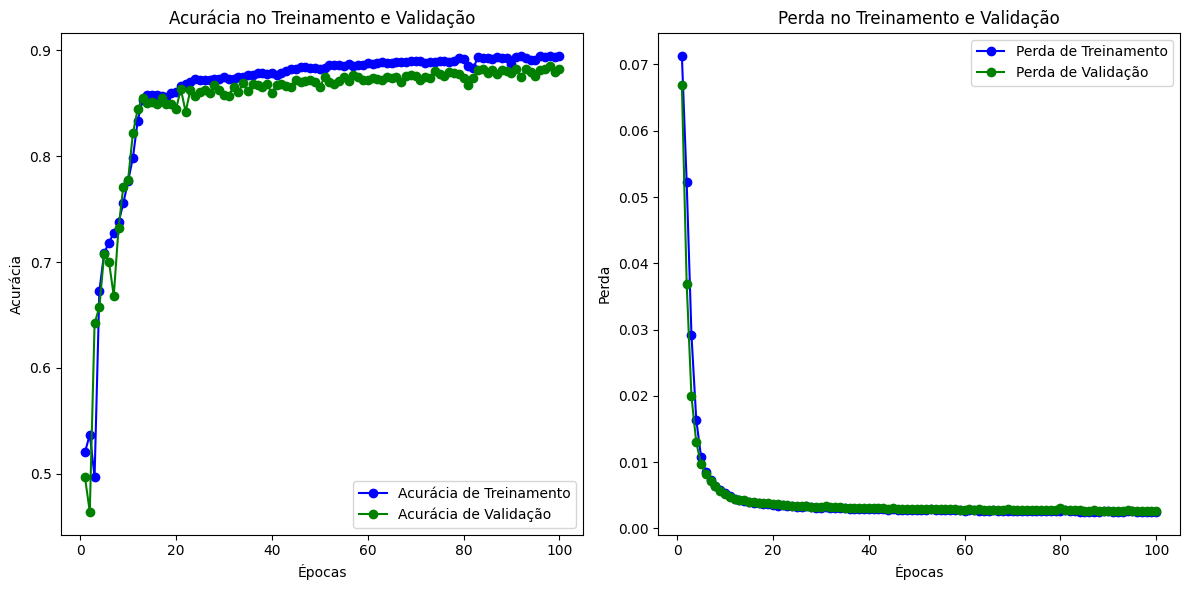

In [8]:
import matplotlib.pyplot as plt

# Acessando os dados de treinamento armazenados no objeto 'history'
# Esse objeto foi retornado pelo método .fit() do modelo
history_dict = history.history

# Extraindo dados de acurácia, perda, e suas respectivas validações
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Definindo o número de épocas
epochs = range(1, len(accuracy) + 1)

# Plotando a acurácia no treinamento e validação
plt.figure(figsize=(12, 6))

# Gráfico de acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Acurácia de Treinamento')
plt.plot(epochs, val_accuracy, 'go-', label='Acurácia de Validação')
plt.title('Acurácia no Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Perda de Treinamento')
plt.plot(epochs, val_loss, 'go-', label='Perda de Validação')
plt.title('Perda no Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print('history')

In [9]:
# Salvar o modelo treinado em um arquivo
autoencoder.save('autoencoder_unet2DIV2K_model.h5')